In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import oenotebook as oenb
import openeye.oechem as oechem

from openmoltools.openeye import smiles_to_oemol, generate_conformers, get_charges, molecule_to_mol2
from openmoltools.utils import get_checkmol_descriptors
import tools as t

In [2]:
results = oenb.read_file_to_dataframe("results_final.oeb.gz")
#len(results)

In [3]:
data = t.stats_array(results["kT log(gamma)_calc (kcal/mol)"], 
                     results["kT log(gamma)_expt (kcal/mol)"], 
                     np.zeros(len(results["kT log(gamma)_expt (kcal/mol)"])), 100, noise=False )
print("kTlog(gamma)_expt x kTlog(gamma)_calc plot")
print("Average error = {:.4f} +- {:.4f}".format(data[0][0], data[0][1]))
print("RMS = {:.4f} +- {:.4f}".format(data[1][0], data[1][1]))
print("AUE = {:.4f} +- {:.4f}".format(data[2][0], data[2][1]))
print("Kendall tau = {:.4f} +- {:.4f}".format(data[3][0], data[3][1]))
print("Pearson R = {:.4f} +- {:.4f}".format(data[4][0], data[4][1]))

kTlog(gamma)_expt x kTlog(gamma)_calc plot
Average error = -0.0752 +- 0.0534
RMS = 0.8142 +- 0.0578
AUE = 0.5814 +- 0.0408
Kendall tau = 0.6119 +- 0.0253
Pearson R = 0.8515 +- 0.0190


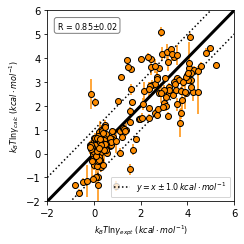

In [4]:
fig = plt.figure(figsize=(3.5,3.5))

textstring = r"R = {:.2f}$\pm${:.2f}".format(data[4][0], data[4][1])


ax = fig.add_subplot(111)
points = ax.errorbar(results["kT log(gamma)_expt (kcal/mol)"], results["kT log(gamma)_calc (kcal/mol)"],
                     xerr=results["kT log(gamma)_expt, error (kcal/mol)"], 
                     yerr=results["kT log(gamma)_calc, error (kcal/mol)"],
                     fmt = 'o', markersize = 6, markeredgewidth=1.0, markeredgecolor='k',
                     color='darkorange',label='_nolegend_')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.05, 0.95, textstring, transform=ax.transAxes, fontsize=8, verticalalignment='top', bbox=props)

ax.plot([-2.0,6.0],[-2.0,6.0],'k-', lw=3)
ax.plot([-2.0,5.0],[-1.0,6.0],'k:',label=r"$y=x\pm1.0\,kcal\cdot mol^{-1}$")
ax.plot([-2.0,7.0],[-3.0,6.0],'k:')
ax.set_xlim([-2.0,6.0])
ax.set_ylim([-2.0,6.0])
ax.set_xlabel(r"$k_BT\ln{\gamma_{expt}}$ ($kcal\cdot mol^{-1}$)", fontsize=8)
ax.set_ylabel(r"$k_BT\ln{\gamma_{calc}}$ ($kcal\cdot mol^{-1}$)", fontsize=8)
ax.legend(loc=4, prop={"size":8})

plt.tight_layout()
plt.savefig("expt_x_calc_kTlog_gamma.pdf")

#plt.close()

**How to use checkmol**
* create a list of sdf files to be created (`idac_{}.mol2`, where `{}` is its row number)
* create oemol structure and save to its respective `.mol2` file
* use checkmol to read `.mol2` files and figure out functional groups
* add them to list and analyze.

In [5]:
names = ['idac_{}.mol2'.format(i) for i in range(len(results))]

In [6]:
results["filename"] = names
for i, row in results.iterrows():
    mol = smiles_to_oemol(row["Solute SMILES"])
    oechem.OETriposAtomNames(mol)
    mol = generate_conformers(mol,max_confs=800,strictStereo=True)
    for j, conf in enumerate(mol.GetConfs()):
        if j > 0:
            mol.DeleteConf(conf)
    molecule_to_mol2(mol,tripos_mol2_filename=row["filename"])

In [7]:
functional_grps = []
for name in names:
    descriptors = get_checkmol_descriptors(name,executable_name = '/usr/local/bin/checkmol')[0]
    functional_grps.append(descriptors)

In [8]:
results["functional groups"] = functional_grps

In [9]:
total_groups = []
for group_list in functional_grps:
    for group in group_list:
        if group not in total_groups:
            total_groups.append(group)
        else: continue
#print(total_groups)

In [10]:
solvents = []
for solvent in results["Solvent name"]:
    if solvent not in solvents:
        solvents.append(solvent)
#print(solvents)

**Next steps:**
* Identify activities containing each functional group/solvent
* Plot points and calculate how far it is from the center curve

In [11]:
def functional_group_statistics(xdata, ydata, xerror, yerror):
    data = t.stats_array(ydata, xdata, np.zeros(len(xdata)),
                         100, noise=False)
    mean_bias_error = (data[0][0], data[0][1])    
    root_mean_square = (data[1][0], data[1][1])
    mean_absolute_error = (data[2][0], data[2][1])
    
    return mean_absolute_error, root_mean_square, mean_bias_error

def plot_per_functional_group(grp, entry, dataframe):
    xgrp = []
    xgrperr = []
    ygrp = []
    ygrperr = []
    for i, row in dataframe.iterrows():
        if grp in row[entry]:
            xgrp.append(row["kT log(gamma)_expt (kcal/mol)"])
            xgrperr.append(row["kT log(gamma)_expt, error (kcal/mol)"])
            ygrp.append(row["kT log(gamma)_calc (kcal/mol)"])
            ygrperr.append(row["kT log(gamma)_calc, error (kcal/mol)"])

    # Stats
    mae, rms, mbe = functional_group_statistics(xgrp, ygrp, 
                                                xgrperr, ygrperr)
    
    textstring = r"AE = {:.1f}$\pm${:.1f} ".format(mbe[0], mbe[1])
    textstring += r"$kcal\cdot mol^{-1}$"
    
    # Plot
    fig = plt.figure(figsize=(3.5,3.5))
    ax = fig.add_subplot(111)
    points = ax.errorbar(dataframe["kT log(gamma)_expt (kcal/mol)"], 
                         dataframe["kT log(gamma)_calc (kcal/mol)"],
                         xerr=dataframe["kT log(gamma)_expt, error (kcal/mol)"], 
                         yerr=dataframe["kT log(gamma)_calc, error (kcal/mol)"],
                         fmt='o', markersize=6, color='darkorange', markeredgewidth=1.0, markeredgecolor='k',
                         label='_nolegend_')
    selected = ax.errorbar(xgrp, ygrp, xerr=xgrperr, yerr=ygrperr, fmt='g*', markersize=12,
                           markeredgewidth=1.0, markeredgecolor='k',
                           label=r"{}".format(grp))
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.05, 0.95, textstring, transform=ax.transAxes,
           fontsize=8, verticalalignment='top', bbox=props)
    
    ax.plot([-2.0,6.0],[-2.0,6.0],'k-', lw=3)
    ax.plot([-2.0,5.0],[-1.0,6.0],'k:',label=r"$y=x\pm1.0\,kcal\cdot mol^{-1}$")
    ax.plot([-2.0,7.0],[-3.0,6.0],'k:')
    ax.set_xlim([-2.0,6.0])
    ax.set_ylim([-2.0,6.0])
    ax.set_xlabel(r"$k_BT\ln{\gamma_{expt}}$ ($kcal\cdot mol^{-1}$)", fontsize=8)
    ax.set_ylabel(r"$k_BT\ln{\gamma_{calc}}$ ($kcal\cdot mol^{-1}$)", fontsize=8)
    ax.legend(loc=4,prop={"size":8})
    plt.tight_layout()
    filename = grp.split(" ")
    plt.savefig("{}_expt_x_calc_kTlog_gamma.pdf".format("_".join(filename)))
    plt.close()
    

In [12]:
interesting_group_names = []
entry = "functional groups"
for elem in total_groups:
    i = 0
    for j, row in results.iterrows():
        if elem in row["functional groups"]:
            i+=1
        else: continue
    if i <= 5: continue
    else:
        interesting_group_names.append(elem)
        plot_per_functional_group(elem, entry, results)


In [13]:
interesting_solvents = []
entry = "Solvent name"
for elem in solvents:
    i = 0
    for j, row in results.iterrows():
        if elem in row["Solvent name"]:
            i+=1
        else: continue
    if i <= 5: continue
    else:
        interesting_solvents.append(elem)
        plot_per_functional_group(elem, entry, results)
        

['sulfoxide', 'primary alcohol', 'dialkyl ether', 'alkane', 'alkene', 'primary amine', 'alkyl chloride', 'aromatic compound', 'aldehyde', 'ketone', 'secondary alcohol', 'alkyl fluoride', 'carboxylic acid ester']


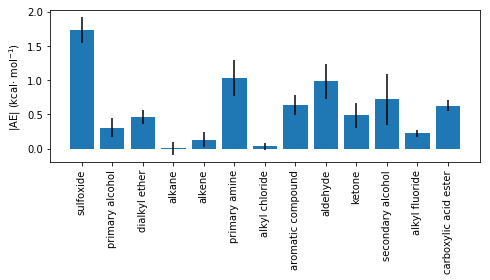

In [14]:
# Plot average unsigned and signed error for each functional group
# with 5 or more points
entry = "functional groups"
grp = []
aue = []
aue_unc = []
ase = []
ase_unc = []

for elem in interesting_group_names:
    
    xgrp = []
    xgrperr = []
    ygrp = []
    ygrperr = []
    
    for i, row in results.iterrows():
        if len(elem) == 0:
            name = 'alkane'
        else: 
            name = elem
        if elem in row[entry]:
            xgrp.append(row["kT log(gamma)_expt (kcal/mol)"])
            xgrperr.append(row["kT log(gamma)_expt, error (kcal/mol)"])
            ygrp.append(row["kT log(gamma)_calc (kcal/mol)"])
            ygrperr.append(row["kT log(gamma)_calc, error (kcal/mol)"])

    # Stats
    mae, rms, mbe = functional_group_statistics(xgrp, ygrp, 
                                                xgrperr, ygrperr)
    grp.append(name)
    aue.append(mae[0])
    aue_unc.append(mae[1])
    ase.append(abs(mbe[0]))
    ase_unc.append(abs(mbe[1]))

# Remove repeated functional group
grp.pop(6)
aue.pop(6)
aue_unc.pop(6)
ase.pop(6)
ase_unc.pop(6)

# Plot
fig = plt.figure(figsize=(7.0,4.0))

ax = fig.add_subplot(111)
ax.bar(grp, ase, yerr=ase_unc)
ax.set_ylabel(r"|AE| (kcal$\cdot$ mol$^{-1}$)", fontsize=10)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.savefig("average_unsigned_error_per_functional_group.pdf")

print(grp)

['pyridine', 'benzene', 'styrene', 'water', 'toluene', 'm-xylene', 'formamide', 'o-xylene', 'p-xylene', 'methanol', 'dodecanoic acid', 'decanoic acid', 'tetradecanoic acid', 'ethylene glycol', 'diethylene glycol']


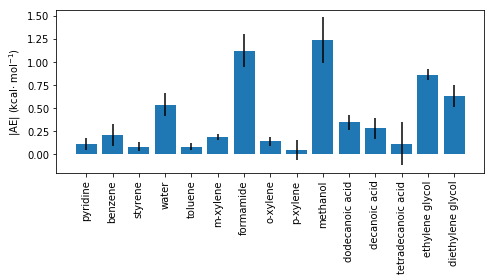

In [15]:
# Plot average unsigned and signed error for each functional group
# with 5 or more points
entry = "Solvent name"
grp = []
aue = []
aue_unc = []
ase = []
ase_unc = []

for elem in interesting_solvents:
    
    xgrp = []
    xgrperr = []
    ygrp = []
    ygrperr = []
    
    for i, row in results.iterrows():
        if len(elem) == 0:
            name = 'alkane'
        elif elem == '2-(2-hydroxyethoxy)ethanol':
            name = 'diethylene glycol'
        else: 
            name = elem
        if elem in row[entry]:
            xgrp.append(row["kT log(gamma)_expt (kcal/mol)"])
            xgrperr.append(row["kT log(gamma)_expt, error (kcal/mol)"])
            ygrp.append(row["kT log(gamma)_calc (kcal/mol)"])
            ygrperr.append(row["kT log(gamma)_calc, error (kcal/mol)"])

    # Stats
    mae, rms, mbe = functional_group_statistics(xgrp, ygrp, 
                                                xgrperr, ygrperr)
    grp.append(name)
    aue.append(mae[0])
    aue_unc.append(mae[1])
    ase.append(abs(mbe[0]))
    ase_unc.append(abs(mbe[1]))

# Plot
fig = plt.figure(figsize=(7.0,4.0))

ax = fig.add_subplot(111)
ax.bar(grp, ase, yerr=ase_unc)
ax.set_ylabel(r"|AE| (kcal$\cdot$ mol$^{-1}$)", fontsize=10)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.savefig("average_unsigned_error_per_solvent.pdf")

print(grp)

In [17]:
# rotatable bonds in the set
rotcounts = []
for mol in results.Molecule:
    nrots = oechem.OECount(mol, oechem.OEIsRotor())
    #print(nrots, oechem.OEMolToSmiles(mol))
    while nrots >= len(rotcounts):
        rotcounts.append(0)
    rotcounts[nrots] += 1

print("Max rotors: {}".format(len(rotcounts)-1))
print("Rotorcount distribution:")
for rots, numrot in enumerate(rotcounts):
    print("\t{}:\t{}".format(rots, numrot))

Max rotors: 13
Rotorcount distribution:
	0:	124
	1:	40
	2:	25
	3:	15
	4:	16
	5:	8
	6:	5
	7:	2
	8:	1
	9:	0
	10:	0
	11:	0
	12:	0
	13:	1


In [18]:
# Molecular weights in the set
molweights = []
for mol in results.Molecule:
    mw = oechem.OECalculateMolecularWeight(mol)
    molweights.append(mw)
    
print("max: {:.2f}\t min: {:.2f}".format(np.array(molweights).max(),np.array(molweights).min()))

max: 226.44	 min: 32.04


In [19]:
results.columns

Index(['Molecule', 'kT log(gamma)_calc, error (kcal/mol)',
       'kT log(gamma)_expt, error (kcal/mol)', 'kT log(gamma)_expt (kcal/mol)',
       'dDG_solv (kcal/mol)', 'Solvent name', 'kT log(gamma)_calc (kcal/mol)',
       'DG_self_solv (kcal/mol)', 'DG_solv (kcal/mol)', 'Temperature (K)',
       'expt IDAC, error', 'dDG_self_solv (kcal/mol)', 'Solvent SMILES',
       'Solute SMILES', 'expt IDAC', 'filename', 'functional groups'],
      dtype='object')

In [20]:
select = results[results['kT log(gamma)_calc (kcal/mol)'] < 0.5]
select = select[select['kT log(gamma)_calc (kcal/mol)'] > -0.5]

In [21]:
near_zero = len(select)
print(near_zero)

94


In [22]:
#select[['Solute SMILES','Solvent SMILES']]

In [23]:
#for string in select['Solvent SMILES']:
#    print(string)

In [24]:
#for string in select['Solute SMILES']:
#    print(string)

In [25]:
# Store shift variance for each solvent
# with 5 or more points
entry = "Solvent name"

solv_vars = {}
for elem in interesting_solvents:
    
    xgrp = []
    xgrperr = []
    ygrp = []
    ygrperr = []
    
    for i, row in results.iterrows():
        if len(elem) == 0:
            name = 'alkane'
        elif elem == '2-(2-hydroxyethoxy)ethanol':
            name = 'diethylene glycol'
        else: 
            name = elem
        if elem in row[entry]:
            xgrp.append(row["kT log(gamma)_expt (kcal/mol)"])
            xgrperr.append(row["kT log(gamma)_expt, error (kcal/mol)"])
            ygrp.append(row["kT log(gamma)_calc (kcal/mol)"])
            ygrperr.append(row["kT log(gamma)_calc, error (kcal/mol)"])

    # Stats
    mae, rms, mbe = functional_group_statistics(xgrp, ygrp, 
                                                xgrperr, ygrperr)
    if abs(mbe[0]) > 0.3:
        solv_vars[elem] = (mbe[0],mbe[1]**2)
    else:
        continue

In [27]:
# Store shift variance for each solute
# with 5 or more points

# Make list of all solutes
solutes = []
for solute in results["Solute SMILES"]:
    if solute not in solutes:
        solutes.append(solute)

# Choose solutes with 5 or more points
entry = "Solute SMILES"
interesting_solutes = []
for elem in solutes:
    i = 0
    for j, row in results.iterrows():
        if elem in row["Solute SMILES"]:
            i+=1
        else: continue
    if i <= 5: continue
    else:
        interesting_solutes.append(elem)

# Store values
solu_vars = {}
for elem in interesting_solutes:
    
    xgrp = []
    xgrperr = []
    ygrp = []
    ygrperr = []
    
    for i, row in results.iterrows():
        if elem in row[entry]:
            xgrp.append(row["kT log(gamma)_expt (kcal/mol)"])
            xgrperr.append(row["kT log(gamma)_expt, error (kcal/mol)"])
            ygrp.append(row["kT log(gamma)_calc (kcal/mol)"])
            ygrperr.append(row["kT log(gamma)_calc, error (kcal/mol)"])

    # Stats
    mae, rms, mbe = functional_group_statistics(xgrp, ygrp, xgrperr, ygrperr)
    if abs(mbe[0]) > 0.3:
        solu_vars[elem] = (mbe[0],mbe[1]**2)
    else:
        continue

In [29]:
solvent_oemol = []
for smiles in results['Solvent SMILES']:
    mol = oechem.OEMol()
    if not oechem.OEParseSmiles(mol, smiles):
        raise ValueError("The supplied SMILES '%s' could not be parsed." % smiles)
        break
    else:
        solvent_oemol.append(mol)

In [30]:
# Molecular weights in the solvent set
molweights = []
for mol in solvent_oemol:
    mw = oechem.OECalculateMolecularWeight(mol)
    molweights.append(mw)
    
print("max: {:.2f}\t min: {:.2f}".format(np.array(molweights).max(),np.array(molweights).min()))

max: 228.37	 min: 18.02


In [31]:
# rotatable bonds in the set
rotcounts = []
for mol in solvent_oemol:
    nrots = oechem.OECount(mol, oechem.OEIsRotor())
    while nrots >= len(rotcounts):
        rotcounts.append(0)
    rotcounts[nrots] += 1

print("Max rotors: {}".format(len(rotcounts)-1))
print("Rotorcount distribution:")
for rots, numrot in enumerate(rotcounts):
    print("\t{}:\t{}".format(rots, numrot))

Max rotors: 12
Rotorcount distribution:
	0:	156
	1:	25
	2:	5
	3:	5
	4:	11
	5:	4
	6:	0
	7:	0
	8:	9
	9:	0
	10:	11
	11:	0
	12:	11
